# Nonequispaced Demo on the $\mathbb T^2$

load libraries and reset random number generator

In [1]:
using Plots, LinearAlgebra, Random
push!(LOAD_PATH, "..")
using FCV
rng = MersenneTwister(7);

## Initialization

In [2]:
d = 2 # dimension
N = 64 # number of frequencies in every dimension
M = 2*N^d # number of nodes
nodes = rand(M,2).- 1/2
s = 3 # degree of sobolev weights
What = [ abs(norm(freq)+1).^s for freq in Iterators.product(ntuple(x -> -N/2:N/2-1, d)...) ] |> vec;

generate sample function values 

In [3]:
function peaks(x, y) # peaks sample function from matlab
  x *= 6
  y *= 6
  z = 3*(1-x)^2*exp(-(x^2) - (y+1)^2) -
    10*(x/5 - x^3 - y^5)*exp(-x^2-y^2) -
    1/3*exp(-(x+1)^2 - y^2) 
  return z
end
fun = peaks
f = [ fun(n...) for n in eachrow(nodes) ];

add noise and create `FCV` object

In [4]:
sigma = 0.1
f_e = f+sigma*(maximum(f)-minimum(f))*randn(rng, size(f))
@time fcv = fcv_t_appr(nodes, f_e, nothing, N);

  5.122743 seconds (8.44 M allocations: 455.855 MiB, 4.36% gc time)


## Computations

compute the cross-validation score and the error for frequency weigths of the form `lambda` times `What` for different values of lambda

In [5]:
lambda = [ exp(t) for t in range(-10,0, length = 25) ]
cv = similar(lambda)
l2err = similar(lambda)

@time for i in eachindex(lambda)
    res = compute(fcv, lambda[i]*What)
    cv[i] = res.gcv
    l2err[i] = 1/M*norm(f-res.f_r)
end

res = compute(fcv, lambda[argmin(cv)]*What);

  9.554657 seconds (6.29 M allocations: 911.749 MiB, 7.85% gc time)


## Plotting

plot the cross-validation score against the actual $L_2$-error

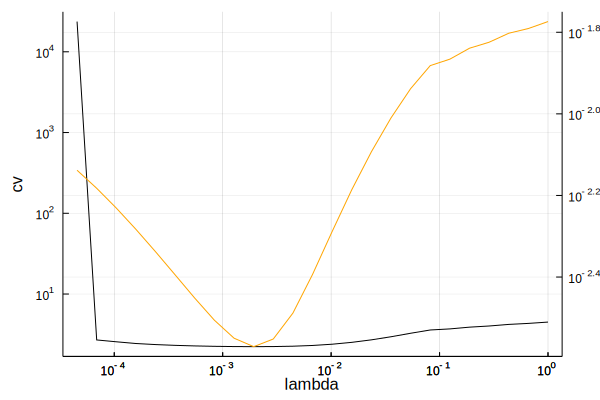

In [6]:
plot(lambda, cv,
  color = :black,
  axis = (:log10),
  xlabel = "lambda",
  ylabel = "cv",
  legend = :none)
plot!(twinx(), lambda, l2err,
  color = :orange,
  legend = :none,
  axis = (:log10),
  ylabel = "l2err",
  guidefontcolor = :orange)

plot the noisy data against the reconstruction with frequency weights corresponding to the minimal cross-validation score

In [7]:
p_noisy = scatter(
    nodes[:, 1],
    nodes[:, 2],
    marker_z = f_e,
    title = "noisy data",
    aspect_ratio = :equal,
    clims = (minimum(f), maximum(f)))

using FFTW
f_p = fft(reshape(res.fhat_r, (N, N)) |> fftshift) |> fftshift |> real

p_reconstruction = heatmap(
    (-N/2:N/2-1)./N,
    (-N/2:N/2-1)./N,
    f_p,
    title = "reconstruction",
    aspect_ratio = :equal,
    clims = (minimum(f), maximum(f)))

plot(p_noisy, p_reconstruction)